In [1]:
import instaloader

import os
import re
import json
import shutil
import lzma

import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import string
from bs4 import BeautifulSoup
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import emoji
from emoji import UNICODE_EMOJI
import contractions
from autocorrect import Speller
from unidecode import unidecode

import scipy.sparse as sps
from scipy.sparse import csr_matrix

import louvain
import igraph as ig

download_dir = os.path.join("data",'raw')
os.makedirs(download_dir, exist_ok=True)

failed_posts = []

loader = instaloader.Instaloader()
# loader.load_session_from_file('rafadimare')

C:\Users\rdm42\anaconda3\lib\site-packages\win_unicode_console\__init__.py:31: RuntimeWarning: sys.stdin.encoding == 'cp1252', whereas sys.stdout.encoding == 'UTF-8', readline hook consumer may assume they are the same
  readline_hook.enable(use_pyreadline=use_pyreadline)
C:\Users\rdm42\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
<ipython-input-1-d98dcfa80be2>:29: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  import louvain


# Recuperación de datos

## Descarga de posts

In [ ]:
xl_path = os.path.join('data','resources','database.xlsx')

already_downloaded = os.listdir(download_dir)

with pd.ExcelFile(xl_path) as xl:
    df = xl.parse() \
           .drop(columns=['id']) \
           .dropna(subset=['link']) \
           .eval("post_code = link.str.split('/').str[-2]") \
           .drop_duplicates(subset=['post_code']) \
           .rename(columns={'Objectify (yes or no)':'objectifies'})
    
pending = df.query("~post_code.isin(@already_downloaded)")
pending

# Check not to drop the row which contains objectify
# Check for missing values on objectify column

df.query("post_code.isin(@already_downloaded)").post_code.to_clipboard(index=False, header=False)

In [ ]:
# for i,post_code in enumerate(pending.post_code.tolist()):
    
#     print(f"{i+1} / {len(pending.post_code.tolist())}")
#     try:    
#         print(f"\tSTART: {pd.Timestamp.now():%H : %M : %S}")
#         print('\t\t'+post_code)
        
#         post = instaloader.Post.from_shortcode(loader.context, post_code)
#         loader.download_post(post, target=post_code)

#         print(f"\t\tEND: {pd.Timestamp.now():%H : %M : %S}")
#         print(f"\n\nPost {post_code} downloaded successfully" + "\n" + "-"*100 + '\n'*2)
#         shutil.move(post_code, download_dir)
        
#     except instaloader.exceptions.InstaloaderException as e:
#         print(f"Error: {e}")
#         failed_posts.append((post_code,e))
        
#     time.sleep(5)

In [ ]:
# # Simple code to retrieve comments

# post_code = "CW6AeAVq3tJ"
# post = instaloader.Post.from_shortcode(loader.context, post_code)
# for comment in post.get_comments():
#     print(comment)

## Lectura de captions

In [ ]:
captions = []

for post_code in os.listdir(download_dir):
    
    post_data_path = os.path.join(download_dir,post_code)

    txt_file = [file for file in os.listdir(post_data_path) if file.endswith('.txt')][0]
    caption_path = os.path.join(post_data_path,txt_file)

    with open(caption_path,'r',encoding='utf-8') as f:
        caption = f.read().strip()
        
    captions.append((post_code, caption))
    
captions = pd.DataFrame(captions, columns=['post_code','caption'])

# captions.head(5)
# df.merge(captions,on='post_code',how='inner')

## Lectura de autocaptions

In [ ]:
autocaptions_path = os.path.join('..','data','auto_gen_captions_rafa.xlsx')
cat_codes_path = os.path.join('..','data','dataframe_codigos.xlsx')

with pd.ExcelFile(autocaptions_path) as xl:
    autocaptions = xl.parse()
    
autocaptions['Long'] = autocaptions['Long'].apply(os.path.splitext).str[0]
autocaptions['Long'] = autocaptions.Long.str.extract("(.*UTC)")[0]
    
with pd.ExcelFile(cat_codes_path) as xl:
    cat_codes = xl.parse(index_col=0)
    

# Obs!! En el catalogo de codigos, el Long sale más de una vez.
# Momentáneamente se descartarán los repetidos
display(cat_codes.Long.value_counts().value_counts())

cat_codes.drop_duplicates('Long',keep=False,inplace=True)

df = autocaptions.merge(cat_codes, on=['Long'], how='outer', validate='m:1', indicator=True)

In [ ]:
#### Obs!!

## Las imágenes y posts no son comparables, _no hay una relación
## uno a uno_. Hay que recordar que cada post puede tener más de una imagen

## Qué hacer? Se podría, por ejemplo, concatenar todas las descripciones de
## imágenes asociadas a un mismo post

In [ ]:
path = os.path.join('..','data','downloaded_posts')

metadata_files = [file[:-8] for file in os.listdir(path) if file.endswith('.json.xz')]

autocaptions.Long.apply(lambda code: metadata_files.count(code)).value_counts()

# autocaptions

In [ ]:
# pd.options.display.max_colwidth = None
# autocaptions.sort_values('Long').head(10)

## Lectura de autocaptions - V2

In [ ]:
autocaptions_path = os.path.join('..','data','auto_gen_captions_rafa.xlsx')

with pd.ExcelFile(autocaptions_path) as xl:
    autocaptions = xl.parse()
    
autocaptions['timestamp'] = autocaptions['Long'].apply(os.path.splitext).str[0] \
                                                .str.extract("(.*UTC)")[0]

path = os.path.join('..','data','downloaded_posts')
autocaptions['metadata_file'] = autocaptions['timestamp'] + '.json.xz'
autocaptions['metadata_file'] = autocaptions['metadata_file'].apply(lambda f: os.path.join(path,f))
autocaptions.head(2)

In [ ]:
# Hay un archivo de imagen al cual no se le encontró
# el correspondiente archivo de metadata

exists = autocaptions.metadata_file.apply(os.path.exists)
autocaptions[~exists]

In [ ]:
def retrieve_metadata(metadata_file):
    
    if os.path.exists(metadata_file):
        with lzma.open(metadata_file, 'rt') as file:
            data_dict = json.load(file)
            
        metadata = dict(
            metadata_file = metadata_file,
            post_code = data_dict['node']['shortcode'],
            user = data_dict['node']['owner']['username'],
            likes = data_dict['node']['edge_media_preview_like']['count'],
        )

        return pd.Series(metadata)
    
    else:
        print(f"File does not exist:\n\t{metadata_file}\n\n")
        cols = ['metadata_file','post_code','user','likes']
        return pd.Series([np.nan]*len(cols),index=cols)

In [ ]:
metadata_cat = autocaptions['metadata_file'].drop_duplicates().apply(retrieve_metadata)

In [ ]:
autocaptions = autocaptions.drop(columns=['post_code','user','likes'], errors='ignore') \
                           .merge(metadata_cat, on='metadata_file', how='left', validate='m:1')

autocaptions_cat = autocaptions.groupby('post_code')['Auto_caption'] \
                               .apply(lambda s: '\n'.join(s.tolist())) \
                               .to_frame().reset_index()

captions = captions.drop(columns='Auto_caption',errors='ignore') \
                   .merge(autocaptions_cat,how='left',validate='1:1')

In [ ]:
captions['text'] = captions['caption'] + '\n\n' + captions['Auto_caption']
captions.head(2)

## Lectura de metadata

In [3]:
additional_data = []

for i,post_code in enumerate(os.listdir(download_dir)):

    post_path = os.path.join(download_dir,post_code)

    metadata_path = os.path.join(post_path,
                                 [file for file in os.listdir(post_path) if file.endswith('.json.xz')][0])
    
    with lzma.open(metadata_path, 'rt') as file:
        data_dict = json.load(file)
        
    user = data_dict['node']['owner']['username']
    likes = data_dict['node']['edge_media_preview_like']['count']

    additional_data.append((post_code,user,likes))

additional_data = pd.DataFrame(additional_data, columns=['post_code','user','likes'])

# additional_data.merge(df).groupby('user').agg({'objectifies':'mean'}).sort_values('objectifies')

## Checkpoint

In [ ]:
output_file = f"posts_data_{pd.Timestamp.now():%Y%m%d_%H%M}.csv"
output_path = os.path.join('data','standardized',output_file)

df.merge(captions).merge(additional_data).to_csv(output_path,index=False,encoding='UTF-16')

# Preparación de datos

## Limpieza superficial

In [ ]:
data_path = os.path.join('data', 'standardized')
data_file = os.path.join(data_path,max(os.listdir(data_path)))

data = pd.read_csv(data_file,encoding='UTF-16')

In [ ]:
contraction_map_path = os.path.join('data','resources','CONTRACTION_MAP.json')
with open(contraction_map_path,'r') as f:
    CONTRACTION_MAP = json.load(f)

In [ ]:
def superficial_cleaning(selftext):
    
    emojis = ' '.join([c for c in selftext if c in UNICODE_EMOJI['en']])

    selftext = contractions.fix(selftext)

    # Remove any HTML tag
    soup = BeautifulSoup(selftext, "html.parser")
    selftext = soup.get_text(separator=" ")

    # Remove any text inside square brackets
    selftext = re.sub(r'\[.*?\]', '', selftext)

    # Remove any website links
    selftext = re.sub(r'http\S+', '', selftext)
    selftext = re.sub(r'www.\S+', '', selftext)
    selftext = selftext.replace('. com', '.com')
    selftext = re.sub(r"\ [A-Za-z]*\.com", " ", selftext)

    # Remove any emojis
    emoji_pattern = re.compile("["
                       u"\U0001F600-\U0001F64F"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U0001F92C"             # 🥴
                       u"\u2764"                 # ❤️
                       u"\u2764\ufe0f"           # ❤️ (with variation selector)
                       "]+", flags=re.UNICODE)
    selftext = emoji_pattern.sub(r'', selftext)

    # Remove '&amp;#x200B;\n\'
    selftext = re.sub(r'&amp;#x200B;\n\\', ' ', selftext)
    selftext = re.sub(r'‚Äú', ' ', selftext)
    selftext = re.sub(r'‚Äô', "’", selftext)

    # Remove accented characters from text using unidecode
    selftext = unidecode(selftext)

    # Convert text to lower case
    selftext = selftext.lower()

    # Remove double spaces, newlines, tabs, and combinations
    selftext = re.sub(r' +', ' ', selftext)
    selftext = re.sub(r'\s{2,}', ' ', selftext)
    selftext = re.sub(r'&gt;', ' ', selftext)
    selftext = selftext.replace('-', ' ')
    selftext = selftext.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ')

#     # Remove any numbers, hashtags and mentions - are dealt with separately
    selftext = re.sub(r'\d+', ' ', selftext)
#     selftext = re.sub(r'#\w+', '', selftext)
#     selftext = re.sub(r'@\w+', '', selftext)

    # Reduce repetition to two characters for alphabets and to
    # one character for punctuations
    Pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)
    Pattern_Punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')
    selftext = Pattern_alpha.sub(r"\1\1", selftext)
    selftext = Pattern_Punct.sub(r'\1', selftext)
    selftext = re.sub(' {2,}',' ', selftext)

    # Expand contractions
    list_Of_tokens = selftext.split(' ')
    for Word in list_Of_tokens:
         if Word in CONTRACTION_MAP:
                list_Of_tokens = [item.replace(Word, CONTRACTION_MAP[Word]) for item in list_Of_tokens]
    selftext = ' '.join(str(e) for e in list_Of_tokens)

    # Remove any special character (After hastages & mentions)
    selftext = re.sub(r"[^a-zA-Z0-9:$-,%.?!]+", ' ', selftext)
    selftext = re.sub(r'%', ' ', selftext)

    # Removing numbers and punctuations
    selftext = re.sub(r"[^a-zA-Z:$-,%.?!]+", ' ', selftext)
    selftext = re.sub(r'[^\w\s]',' ',selftext)

    # Remove extra whitespaces from the text
    pattern = re.compile(r'\s+')
    Without_whitespace = re.sub(pattern, ' ', selftext)
    selftext = Without_whitespace.replace('?', ' ? ').replace(')', ') ')

    # Check for spellings in English language - very slow
    #spell = Speller(lang='en')
    #selftext = spell(selftext)
    #selftext = re.sub(r'[^\w\s]', '', selftext)
    
    selftext += ' ' + emojis

    return selftext

In [ ]:
# pd.set_option('display.max_rows', None)
# pd.options.display.max_colwidth = None

text_col = 'text'

data['text_sup_clean'] = data[text_col].apply(superficial_cleaning)


# collection of words
words = np.unique([item for sublist in data['text_sup_clean'].str.split() for item in sublist])
documents = data[text_col].values

# words dictionary
words_dict = {v:k for k,v in enumerate(words)}

In [ ]:
data.head(2)

## Lectura de captions procesados por Daniel - 08/01/2024

In [4]:
captions_path = os.path.join('..','data','captions_autocaptions_clean.xlsx')
s = ' '

text_col = 'clean_caption'

with pd.ExcelFile(captions_path) as xl:
    data = xl.parse(index_col=0) \
             .merge(additional_data, left_on='Short', right_on='post_code', how='left', validate='m:1') \
             .drop(columns=['post_code'])
    
for col in ['clean_caption','clean_autocaption','All_text']:
    data[col] = data['user'] + ' ' + data[col]

# collection of words
words = np.unique([item
                   for sublist in data.dropna(subset=[text_col])[text_col].str.split()
                   for item in sublist])

documents = data[text_col].values

# words dictionary
words_dict = {v:k for k,v in enumerate(words)}

## Exploración inicial

In [5]:
# occurrence matrix for words
Mwd = csr_matrix((len(words_dict), data.shape[0]), dtype = np.int8).toarray()

for j,doc in data.dropna(subset=[text_col])[text_col].items():
    for word in doc.split():
        Mwd[words_dict[word],j] += 1

In [6]:
k = Mwd.sum(axis=1)
gamma = 1 + k.size/np.log(k / k.min()).sum()
print(f"Network's gamma is {gamma:.2f}")

Network's gamma is 3.04


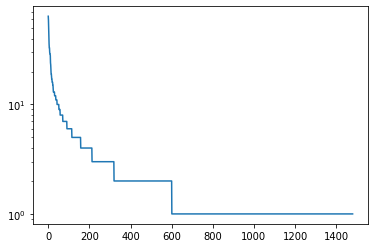

In [7]:
plt.figure()
plt.semilogy(-np.sort(-np.sum(Mwd,axis=1)))

(320, 265)

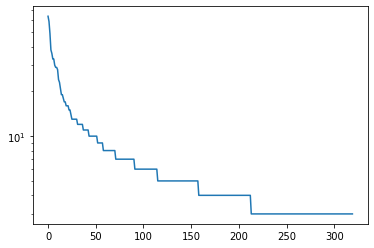

In [8]:
# remove words that are used once or twice
select = Mwd.sum(axis=1) > 2
Mwd = Mwd[select,:]
words = words[select]

# remove documents that do not contain words
select = Mwd.sum(axis=0) > 0
Mwd = Mwd[:,select]
documents = documents[select]

# display final matrix size
display(Mwd.shape)

plt.figure()
plt.semilogy(-np.sort(-np.sum(Mwd,axis=1)))

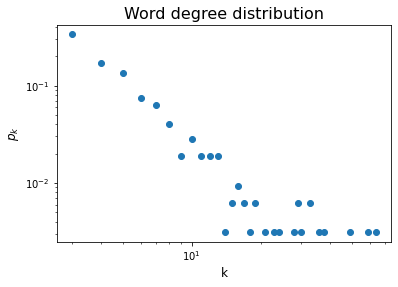

In [9]:
# degree distribution for words
dw = np.squeeze(Mwd.sum(axis=1)) # words degrees
k = np.unique(dw)
pk = np.histogram(dw,np.append(k,k[-1]+1))[0]
pk = pk/pk.sum()
Pk = 1-np.cumsum(pk)

fig = plt.figure()
plt.loglog(k,pk,'o')
plt.title("Word degree distribution", size=16)
plt.xlabel("k", size=12)
plt.ylabel("$p_k$", size=12)
plt.show()

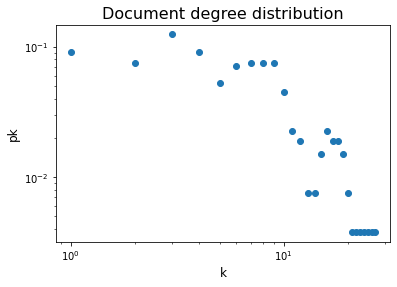

In [10]:
# degree distribution for documents
dd = np.squeeze(Mwd.sum(axis=0)) # documents degrees
k = np.unique(dd)
pk = np.histogram(dd,np.append(k,k[-1]+1))[0]
pk = pk/pk.sum()
Pk = 1-np.cumsum(pk)
fig = plt.figure()

plt.loglog(pk,'o')
plt.title("Document degree distribution", size=16)
plt.xlabel("k", size=12)
plt.ylabel("pk", size=12)
plt.show()

## Construcción de matrices

In [11]:
def clean_Mwd_matrix(Mwd,words,documents):

    # remove elements that are too central, e.g., #covid19
    not_wanted = Mwd.sum(axis=1) > Mwd.shape[1]/4
    text = "removing: " + ", ".join(words[not_wanted])
    words = words[~not_wanted]
    Mwd = Mwd[~not_wanted,:]

    # remove documents and words with fewer than 2 links
    while True:
        dim_old = Mwd.size
        
        # remove documents with less than 2 words
        wanted = Mwd.sum(axis=0) >= 2
        Mwd = Mwd[:,wanted]
        documents = documents[wanted]

        # remove words in less than 2 documents
        not_wanted = Mwd.sum(axis=1) < 2
        text = text + ", " + ", ".join(words[not_wanted])
        words = words[~not_wanted]
        Mwd = Mwd[~not_wanted,:]
        
        # exit criterion
        if (dim_old == Mwd.size): break

    print(text)
    return Mwd, words, documents

def logg(x):
    y = np.log(x)
    y[x==0] = 0
    return y



def probability_matrices(Mwd, equalik = True, tform = False):

    if equalik: # documents equally likely
        Pwd = Mwd/Mwd.sum(axis=0) #/ Mwd.shape[1]    ## Por qué aquí se divide entre el número de columnas???
        
    else: # documents proportional to their length
        Pwd = Mwd / Mwd.sum()                       ## Aquí la suma por columnas no da 1!!! entonces no es matriz estocástica
    # TF-IDF format
    
    if (tform):
        iw = -logg(np.sum(Mwd>0,axis=1).flatten()/Mwd.shape[1])
        Pwd = sps.diags(np.array(iw)[0])*Pwd # TF-IDF form
        Pwd = Pwd/Pwd.sum() # normalize, treat it as Pwd
        
    
    
    # Creo que aquí debe ser .dot ..............
    
    # words and document matrices
    pd = Pwd.sum(axis=0)
    Pww = (Pwd/pd).dot(Pwd.T)
    
    pw = Pwd.sum(axis=1)
    Pdd = (Pwd.T/pw).dot(Pwd)
    
    
    # Aquí no entiendo y no sé qué utilidad tiene.............................
    
    # joint words and document matrix - documents first
    Paa = sps.hstack((sps.csr_matrix((Pwd.shape[1],Pwd.shape[1])),Pwd.T))
    Paa = sps.vstack((Paa,sps.hstack((Pwd,sps.csr_matrix((Pwd.shape[0],Pwd.shape[0]))))))
    Paa = Paa/2.0

    
    
    # Los auto-enlaces están permitidos????
    
    return Pwd, Pww, Pdd, Paa

Mwd, words, documents = clean_Mwd_matrix(Mwd,words,documents)
Pwd, Pww, Pdd, Paa = probability_matrices(Mwd, tform=False)

removing: , , 


,Id,obj_rate
0,accessory,1.00
1,aesthetic,0.50
2,all,0.75


,obj_rate
count,320.000000
mean,0.594175
std,0.316140
min,0.000000
25%,0.333333
50%,0.666667
75%,0.833333
max,1.000000


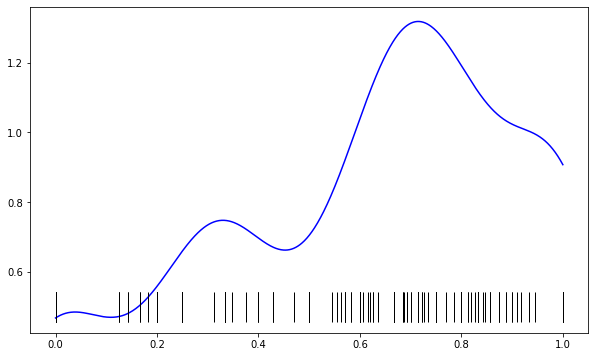

In [27]:
Mwd_df = pd.DataFrame(Mwd,index=words,columns=documents)

obj_docs = data.set_index(text_col) \
               .query("Objectify==1") \
               .index.drop_duplicates() \
               .intersection(Mwd_df.columns)


# Objectification rate for each word catalogue
# obj_rate = times the word is used in an objectifying post / times the word is used
obj_rate_cat = (Mwd_df[obj_docs].sum(axis=1) / Mwd_df.sum(axis=1)) \
               .to_frame().rename(columns={0:'obj_rate'}) \
               .reset_index(names='Id')

display(obj_rate_cat.head(3))
display(obj_rate_cat.describe())


from scipy.stats import gaussian_kde

plt.figure(figsize=(10, 6))

kde = gaussian_kde(obj_rate_cat['obj_rate'])
x_vals = np.linspace(obj_rate_cat['obj_rate'].min(), obj_rate_cat['obj_rate'].max(), 1000)
y_vals = kde(x_vals)

# Plot KDE
plt.plot(x_vals, y_vals, color='blue', label='KDE')
plt.plot(obj_rate_cat['obj_rate'].values, [0.5] * len(obj_rate_cat), '|', color='black', markersize=30)


### La distribución luce bimodal!!

In [13]:
k = Mwd.sum(axis=1)
gamma = 1 + k.size/np.log(k / k.min()).sum()
print(f"Network's gamma is {gamma:.2f}")

Network's gamma is 2.04


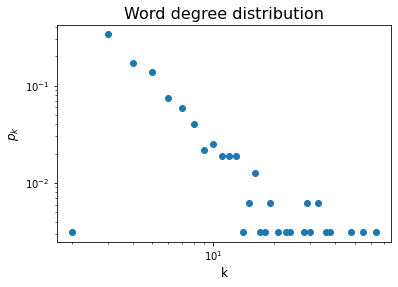

In [14]:
dw = Mwd.sum(axis=1) # words degrees
k = np.unique(dw)
pk = np.histogram(dw,np.append(k,k[-1]+1))[0]
pk = pk/pk.sum()
Pk = 1-np.cumsum(pk)

fig = plt.figure()
plt.loglog(k,pk,'o')
plt.title("Word degree distribution", size=16)
plt.xlabel("k", size=12)
plt.ylabel("$p_k$", size=12)
plt.show()

In [19]:
df = pd.DataFrame(Pww,index=words,columns=words) \
       .stack() \
       .to_frame() \
       .reset_index(names = ['Source','Target']) \
       .rename(columns={0:'Weight'}) \
       .query("Source != Target") \
       .replace(UNICODE_EMOJI['en']) \
       .query("Weight != 0")

df['temp_key'] = df.apply(lambda row: ''.join(sorted([row['Source'],row['Target']])),axis=1)
df = df.drop_duplicates('temp_key') \
       .drop(columns=['temp_key']) \
       .reset_index(drop=True)

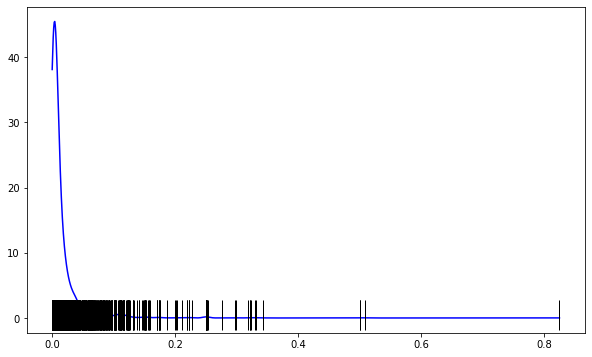

In [20]:
from scipy.stats import gaussian_kde

plt.figure(figsize=(10, 6))

kde = gaussian_kde(df['Weight'])
x_vals = np.linspace(df['Weight'].min(), df['Weight'].max(), 1000)
y_vals = kde(x_vals)

# Plot KDE
plt.plot(x_vals, y_vals, color='blue', label='KDE')
plt.plot(df['Weight'].values, [0.5] * len(df), '|', color='black', markersize=30)

In [21]:
df['Weight'].describe()

count    6601.000000
mean        0.015340
std         0.031928
min         0.000308
25%         0.002770
50%         0.005671
75%         0.015625
max         0.824846
Name: Weight, dtype: float64

In [22]:
tol = 0.05/2
df.query("Weight > @tol")['Weight'].describe()

count    990.000000
mean       0.065593
std        0.060271
min        0.025207
25%        0.032133
50%        0.041779
75%        0.074846
max        0.824846
Name: Weight, dtype: float64

In [26]:
tol = 0.05/4
df2 = df.query("Weight > @tol")

df.sort_values('Weight').to_csv(f'data/processed/col_{text_col}__tol_{tol}__links.csv',encoding='UTF-16',index=False)

pd.concat([df.Source,df.Target],ignore_index=True) \
  .drop_duplicates() \
  .to_frame() \
  .rename(columns={0:'Id'}) \
  .eval("Label=Id") \
  .merge(obj_rate_cat,how='left',on='Id',validate='m:1') \
  .to_csv(f'data/processed/col_{text_col}__tol_{tol}__nodes.csv',encoding='UTF-16',index=False)